### Train autoencoder network
- This notebook trains a convolutional autoencoder on the hdf5 dataset created by the syllable segmentation notebooks. 
- The trained model is then used to perform dimensionality reduction and generate novel stimuli

#### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline  
import os
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import hdbscan 
from datetime import datetime

In [3]:
from avgn.network_analysis.network_analysis import *
import avgn.network.convnet_model as conv
from avgn.network.training import *

#### Allocate GPUs

In [4]:
gpus = [1] # Here I set CUDA to only see one GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1 

In [5]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print( [x.name for x in local_device_protos if x.device_type == 'GPU'] )

['/device:GPU:0']


#### Define data parameters

In [6]:
dims = [128, 128, 1] # first dimension of input data
batch_size = 16 # size of batches to use (per GPU)

### Load the dataset

In [7]:
from glob import glob

### Load the dataset

In [8]:
from glob import glob

In [9]:
bird_name = 'CAVI_vae' 

In [10]:
hdf_locs = glob('../../../data/CAVI_wavs/*_'+str(dims[0])+'.hdf5')
#hdf_locs = glob('../../../data/CAVI_wavs/*.hdf5')
#hdf_locs = [i for i in hdf_locs if '_128' not in i]
hdf_locs[:4]

['../../../data/CAVI_wavs/YBuA_128.hdf5',
 '../../../data/CAVI_wavs/GRA_128.hdf5',
 '../../../data/CAVI_wavs/YAW_128.hdf5',
 '../../../data/CAVI_wavs/AGBk_128.hdf5']

In [11]:
def load_from_hdf5(hdf_locs, to_load):
    """Loads content from a list of HDF5 files"""
    hdf5_content = {}
    with h5py.File(hdf_locs[0],'r') as hf:
        for tl in to_load:
            hdf5_content[tl] = hf[tl].value
        hdf5_content['name'] = np.repeat(list(hf.attrs.values())[0], np.shape(hf['spectrograms'].value)[0])
        
    for i, folder in enumerate(hdf_locs[1:]):
        with h5py.File(folder,'r') as hf:
            if len(hf[to_load[0]].value) < 2500: continue
            print(folder, len(hf[to_load[0]].value))
            for tl in to_load:
                hdf5_content[tl] = np.append(hdf5_content[tl], hf[tl].value, axis = 0)
            hdf5_content['name'] = np.append(hdf5_content['name'], np.repeat(list(hf.attrs.values())[0], np.shape(hf['spectrograms'].value)[0]))
    return hdf5_content

In [12]:
# What information is stored in the HDF5 file
to_load = ['spectrograms', 'lengths', 'start', 'wav_file', 'syll_start_rel_wav', 'symbols']

In [13]:
all_content = load_from_hdf5(hdf_locs, to_load)
num_examples = len(all_content['name'])
num_examples

../../../data/CAVI_wavs/GRA_128.hdf5 3045
../../../data/CAVI_wavs/YAW_128.hdf5 3149
../../../data/CAVI_wavs/AGBk_128.hdf5 8185
../../../data/CAVI_wavs/AGO_128.hdf5 3869
../../../data/CAVI_wavs/WABk_128.hdf5 6430
../../../data/CAVI_wavs/BuRA_128.hdf5 5527
../../../data/CAVI_wavs/AOBu_128.hdf5 7638
../../../data/CAVI_wavs/ORA_128.hdf5 2805
../../../data/CAVI_wavs/RYA_128.hdf5 3565


46851

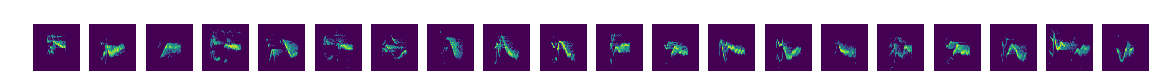

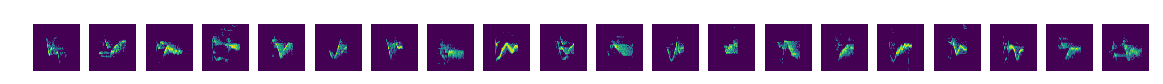

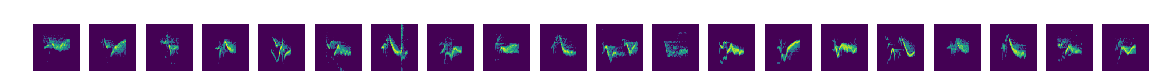

In [14]:
nex=20
for i in range(3):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex,1))
    for i in range(nex):
        ax[i].matshow(all_content['spectrograms'][np.random.randint(len(all_content['spectrograms']))].reshape((dims[0],dims[1])),
                      cmap=plt.cm.viridis, interpolation='nearest', origin='lower')
        ax[i].axis('off')

#### Split dataset into training and validation sets 

In [15]:
val_pct = .1 # how much of the dataset to set aside for validation of reconstruction

In [16]:
validation_set = np.random.permutation(np.arange(len(all_content['spectrograms'])))[:int(len(all_content['spectrograms'])*val_pct)]
mask = np.ones(len(all_content['spectrograms']), np.bool)
mask[validation_set] = 0
validation_syllables = all_content['spectrograms'][validation_set]
training_syllables = all_content['spectrograms'][mask]
print(len(training_syllables), len(validation_syllables))

42166 4685


In [17]:
# define a training iterator over your data
iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)

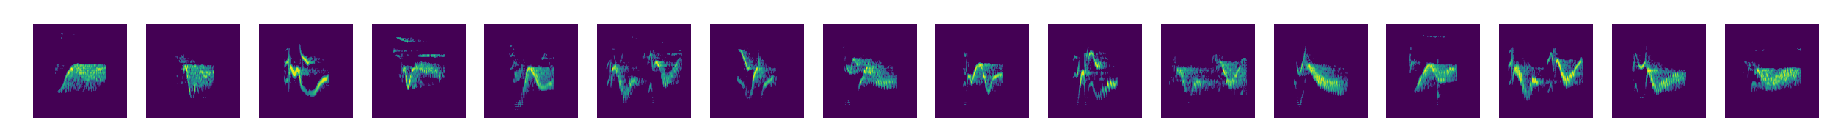

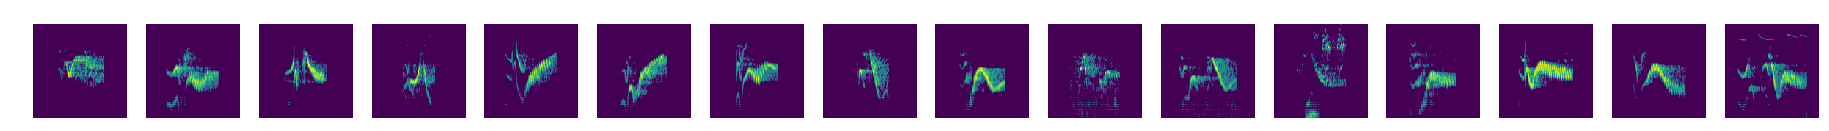

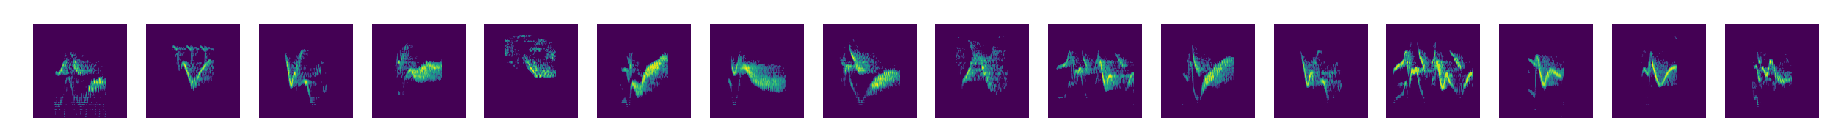

In [18]:
nex=16

for ii in range(3):
    example_data = iter_.__next__()[0]
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex*2,1*2))
    for i in range(nex):
        ax[i].matshow(example_data[i].reshape((dims[0],dims[1])), cmap=plt.cm.viridis, interpolation='nearest', origin='lower', vmin=0, vmax=1)
        ax[i].axis('off')
    plt.show()

### Define the network
#### Network dimensions

In [19]:
# dimensions of network
# [depth, filter size, stride] # decoder will become inverse of encoder
filt = 32
encoder_dims = [
    [filt, 3, 1],  # 64
    [filt, 3, 2], # 64
    [filt*2, 3, 1], # 64
    [filt*2, 3, 2], # 32
    [filt*3, 3, 1], # 32
    [filt*3, 3, 2], # 16
    [filt*4, 3, 1], # 16
    [filt*4, 3, 2], # 16
    [filt*4, 3, 1], # 16
    [2000, 0, 0], # 8
]
decoder_dims = encoder_dims[::-1]
hidden_size = 16
latent_loss = 'VAE' # Either 'None', 'distance', or 'VAE'

In [20]:
# Generate a unique key (e.g. datetime) for this training instance
network_identifier = 'VAE_'+bird_name
now_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # this is used to identify this training instance
print(now_string)

2018-10-22_16-36-01


In [21]:
import pickle

In [22]:
# save params
param_loc = '../../../data/network_params/'+network_identifier+'/'
print(param_loc+now_string+'_params.pickle')
if not os.path.exists(param_loc):
                os.makedirs(param_loc) 
with open(param_loc+now_string+'_params.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([encoder_dims, decoder_dims, hdf_locs, dims, batch_size, hidden_size, validation_set, latent_loss], f)        

../../../data/network_params/VAE_CAVI_vae/2018-10-22_16-36-01_params.pickle


In [23]:
model = conv.ConvAE(dims, batch_size, encoder_dims, decoder_dims, hidden_size, latent_loss=latent_loss, network_type='AE', gpus=[0], adam_eps = 1.0e-8, activation_fn=tf.nn.elu) # eps = 0.1 and lr = 1 (after lr 0.1)

Encoder shapes:  [(16, 128, 128, 1), (16, 128, 128, 32), (16, 64, 64, 32), (16, 64, 64, 64), (16, 32, 32, 64), (16, 32, 32, 96), (16, 16, 16, 96), (16, 16, 16, 128), (16, 8, 8, 128), (16, 8192), (16, 2000)]
Decoder shapes:  [(16, 16), (16, 2000), (16, 16, 16, 128), (16, 32, 32, 128), (16, 32, 32, 128), (16, 64, 64, 128), (16, 64, 64, 96), (16, 128, 128, 96), (16, 128, 128, 64), (16, 256, 256, 64), (16, 256, 256, 32), (16, 128, 128, 32), (16, 128, 128, 1), (16, 16384)]
Network Initialized


### Train the model

#### train a single epoch to test

In [24]:
### Parameters, etc...
num_epochs = 50 # how many epochs to train the network for
epoch = 0 # initialize epochs
save_loc = '../../../data/models/'+network_identifier + '/'+now_string+'/'
print(save_loc)
# Visualizations (these only work if you choose a 2D latent space - write a new viz function if you didn't...)
network_save_epochs = np.unique(np.logspace(0,np.log2(num_epochs),num=20, base= 2).astype('int')) # (epochs) - which epochs to save the network
network_save_epochs=network_save_epochs[network_save_epochs>50]
#network_visualize_progress = np.unique(np.logspace(0,np.log2(num_epochs),num=10000, base= 2).astype('int')) # how often to visualize the network (leave empty list for never)
network_visualize_progress = np.arange(num_epochs)
img_save_loc = '../../../img/'+network_identifier + '/'+now_string+'/'
learning_rate = 1e-4
latent_loss_weights = 1.0#1e-2

../../../data/models/VAE_CAVI_vae/2018-10-22_16-36-01/


In [25]:
# a list of which tensors to return from the network (e.g. train_D/G are necessary to train the network, losses are useful for plots)
return_list = ['train_D', 'train_E', 'L_d', 'L_e', 'recon_loss', 'KL_loss'] 
iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
validation_iter_ = data_iterator(validation_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)

#train_AE(model, iter_,dataset_size = len(training_syllables), validation_iter_=False, learning_rate = 1.0, return_list=return_list)
training_df, validation_df = train_AE(model, iter_,dataset_size = int(len(training_syllables)/100), validation_iter_=validation_iter_,validation_size=len(validation_syllables),
                                      learning_rate = learning_rate, return_list=return_list, latent_loss_weights=latent_loss_weights)

In [26]:
training_df[:3]

,batch,train_D,train_E,L_d,L_e,recon_loss,KL_loss
0,1,None,None,"[11357.43, 11358.054, 11358.255, 11358.364, 11...","[11357.666, 11358.29, 11358.491, 11358.601, 11...",181725.578125,0.236315
1,2,None,None,"[11112.421, 11006.434, 11039.834, 11093.484, 1...","[11115.684, 11009.696, 11043.097, 11096.747, 1...",176419.515625,3.262876
2,3,None,None,"[9767.952, 10088.204, 9864.711, 9791.568, 9853...","[9783.327, 10103.579, 9880.086, 9806.943, 9868...",158390.406250,15.374963


#### Train the network in full

In [27]:
#model.load_network('../../../../data/models/Distance_AE_CAVI/2018-10-17_10-00-27/28_model.tfmod')

6


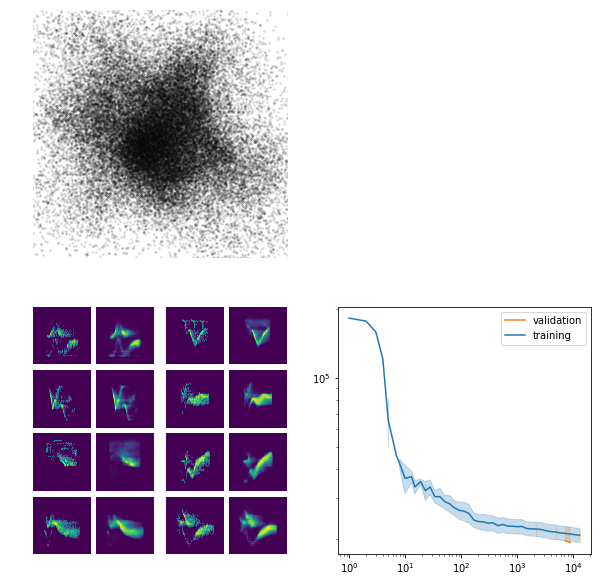

In [ ]:
try:
    for epoch in tqdm(range(epoch,num_epochs)):
     
        # visualization
        if epoch in network_visualize_progress:
            clear_output()
            print(epoch)
            visualize_2D_AE(model, training_df, validation_df, example_data, num_examples,
                            batch_size, num_gpus, dims, iter_, n_cols = 4, std_to_plot = 2.5,
                            save_loc = img_save_loc+now_string+'/'+str(epoch)+'.jpg')
        
        # training
        iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
        validation_iter_ = data_iterator(validation_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
        training_df_epoch, validation_df_epoch = train_AE(model, iter_, dataset_size = len(training_syllables),
                                              validation_iter_=validation_iter_,validation_size=len(validation_syllables),
                                              learning_rate = learning_rate, return_list=return_list,
                                                         latent_loss_weights=latent_loss_weights)
        training_df = pd.concat([training_df, training_df_epoch])
        validation_df = pd.concat([validation_df, validation_df_epoch])
        
        # save network
        #if epoch in network_visualize_progress:
        #    if not os.path.exists(save_loc):
        #        os.makedirs(save_loc) 
        #    model.save_network(save_loc+str(epoch)+'_model.tfmod')
        
except KeyboardInterrupt:
    print('interrupted by keyboard')

In [ ]:
%debug

In [ ]:
### save this model
if not os.path.exists(save_loc+'manual/'):
    os.makedirs(save_loc+'manual/') 
model.save_network(save_loc+'manual/manual_model.tfmod')

### Translate syllables into latent space

In [ ]:
print('test')

In [ ]:
def encode_x(x, z_shape,batch_size):
    nex =np.ceil(len(x)/batch_size).astype('int')
    face_z = np.zeros([nex*batch_size] + list(z_shape))
    face_x = np.zeros([nex*batch_size] + list(np.shape(x)[1:]))
    face_x[:len(x)] = x
    for batch in np.arange(nex):
        cur_batch = face_x[int(batch*batch_size):int((batch+1)*batch_size)]
        z_out = model.sess.run(model.z_x,{model.x_input: cur_batch})
        face_z[batch*batch_size:(batch+1)*batch_size,:] = z_out
    z_final = face_z[:len(x)]
    return z_final

def decode_z(z, x_shape, batch_size):
    nex =np.ceil(len(z)/batch_size).astype('int')
    face_x = np.zeros([nex*batch_size] + list(x_shape))
    face_z = np.zeros([nex*batch_size] + list(np.shape(z)[1:]))
    face_z[:len(z)] = z
    for batch in np.arange(nex):
        cur_batch = face_z[int(batch*batch_size):int((batch+1)*batch_size)]
        x_out = model.sess.run(model.x_tilde,{model.z_x: cur_batch})
        face_x[batch*batch_size:(batch+1)*batch_size,:] = x_out
    x_final = face_x[:len(z)]
    return x_final

In [ ]:
x = all_content['spectrograms']/255.
z = encode_x(np.reshape(x, (len(x), np.prod(np.shape(x)[1:]))), [64], model.batch_size)
print(np.shape(z))

### Interpolate between syllables

In [ ]:
### choose two points
# get their z values
# interpolate between those z values
# pass those z values into network (encode them)
# plot a figure of this interpolation, save a gif

In [ ]:
pt1 = 0; pt2 = 1
syllable_1 = all_content['spectrograms'][pt1]
syllable_2= all_content['spectrograms'][pt2]
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,3))
ax[0].matshow(syllable_1, origin = 'lower'); ax[0].axis('off')
ax[1].matshow(syllable_2, origin = 'lower'); ax[1].axis('off')

In [ ]:
n_frames_per_interp = 16 # how many points in interp.
z1 = encode_x(np.array([syllable_1.flatten()/255.]), [hidden_size], batch_size)[0]
z2 = encode_x(np.array([syllable_2.flatten()/255.]), [hidden_size], batch_size)[0]
pcts = np.linspace(0,1,n_frames_per_interp+1)[:-1]
interp_z = np.array([(z1*pct) + (z2*(1.-pct)) for pct in tqdm(pcts, leave=False)])
x_interp = decode_z(interp_z, [np.prod(dims[:-1])], batch_size)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10))
ax.plot([z1[0],z2[0]], [z1[1],z2[1]], color='red', lw=5)
ax.scatter(z[:,0], z[:,1], color='k', s=1, alpha=.2)

#ax.scatter(xv, yv, color='r', s=30)
ax.axis('off')
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=n_frames_per_interp, figsize=(n_frames_per_interp*3,3))
for frame in range(n_frames_per_interp):
    ax[frame].matshow(np.squeeze(x_interp[frame].reshape(dims)), origin = 'lower')
    ax[frame].axis('off')

### Demo recovering audio from a generated syllable

In [ ]:
import pickle
import avgn.spectrogramming.spectrogramming as sg
import skimage.transform
import IPython.display
from PIL import Image

In [ ]:
# load dictionary with spectrogram parameters
dict_now_string = '2018-10-17_13-40-37'
dict_loc = '../../../data/parameter_dictionaries/'+dict_now_string+'_dict.pickle'
with open(dict_loc, 'rb') as f:
    hparams = pickle.load(f)
globals().update(hparams)

In [ ]:
_mel_basis = sg._build_mel_basis(hparams) # build a basis function if you are using a mel spectrogram
mel_inversion_filter = (_mel_basis.T / _mel_basis.sum(axis=1))
mel_inversion_filter =np.nan_to_num(np.transpose(mel_inversion_filter / mel_inversion_filter.sum(axis=1)[:, np.newaxis]))

In [ ]:
def rescale(X, out_min, out_max):
    return out_min + (X - np.min(X)) * ((out_max - out_min) / (np.max(X) - np.min(X)))

In [ ]:
def invertSyllableToWav(syll, dims, hparams):
    syll = np.squeeze(syll.reshape(dims))
    # reshape spectrogram 
    if hparams['mel_filter']:
        resize_shape = (int((np.shape(syll)[1]/hparams['resize_samp_fr']) * (1000/hparams['frame_shift_ms'])), hparams['num_freq_final'])
        syll = np.array(Image.fromarray(np.squeeze(syll)).resize(resize_shape, Image.ANTIALIAS))
        syll = np.dot(syll.T, mel_inversion_filter).T
    else:
        resize_shape = (int((np.shape(syll)[1]/hparams['resize_samp_fr']) * (1000/hparams['frame_shift_ms'])), hparams['num_freq'])
        syll = np.array(Image.fromarray(np.squeeze(syll)).resize(resize_shape, Image.ANTIALIAS))
    ### adding some noise tends to improve reconstruction quality
    syll = rescale(syll, .25,1) +np.reshape(np.random.rand(np.prod(np.shape(syll)))*.25, np.shape(syll))
    # invert spectrogram
    waveform = sg.inv_spectrogram(rescale(syll, .25,1), hparams)
    return waveform


In [ ]:
invert_wavs = [invertSyllableToWav(i, dims, hparams) for i in tqdm(x_interp)]

In [ ]:
len(invert_wavs[0])

In [ ]:
# play back a sample of the song
IPython.display.Audio(data=np.concatenate(invert_wavs), rate=hparams['sample_rate'])